In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
import sys as sys
import time
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT

This cell initializes some example AMR grid.

In [2]:
# [1] means 2nd index on "lowest level"
cells = [[0,1], [2,3]] #, [4, 5], [8, 9, 11]] #, [16, 17, 19, 22]]
omega = BT.Grid(2) # base grid has 2 cells
for i in cells:
    omega.AddCell(2, i) # 2 means ref ratio?, i is the indices of the cells to be refined

This cell computes the node-centered and cell-centered modes of the `omega` grid object and then plots them.

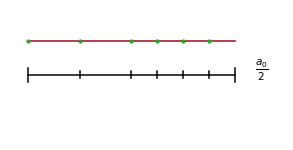

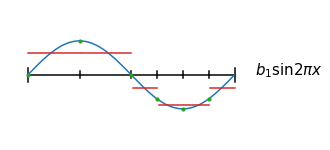

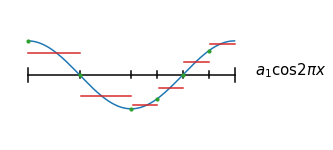

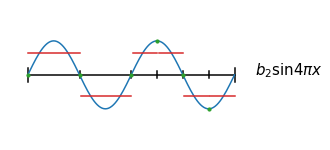

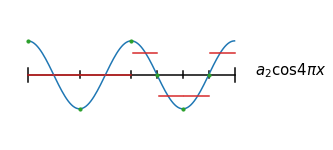

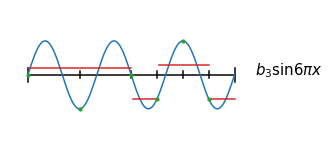

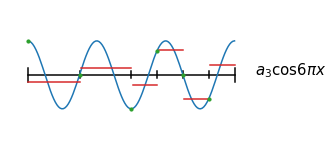

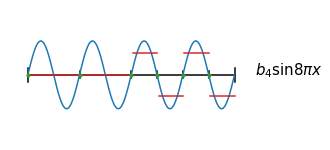

In [3]:
waves = WT.MakeWaves(omega)
wavesNode = WT.MakeNodeWaves(omega)
PT.PlotWaves(omega, waves, wavesNode, plotNode = True)

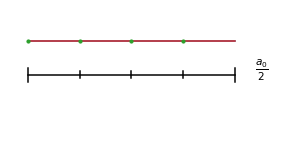

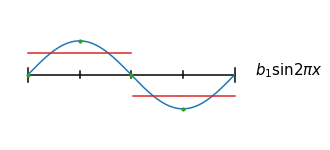

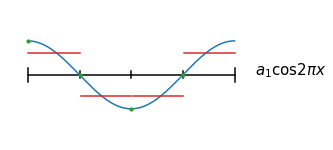

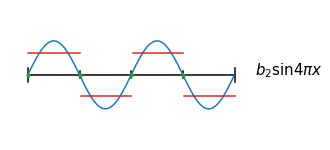

In [4]:
omegaC = BT.Grid(4)
wavesC = WT.MakeWaves(omegaC)
wavesNodeC = WT.MakeNodeWaves(omegaC)
PT.PlotWaves(omegaC, wavesC, wavesNodeC, plotNode = True)
fft_C = wavesC.transpose() # forward FFT on coarse grid, but needs "unit amplitude" scaling
d = np.diag(fft_C @ wavesC) # this is the scaling for each wave #
fft_C = np.diag(1 / d) @ fft_C # this corrects for scaling
# print(fft_C @ wavesC) # should be identity
invfft_C = np.linalg.inv(fft_C) # inverse FFT on coarse grid
assert(np.linalg.norm(invfft_C - wavesC, 'fro') < 1e-15)  # This should get us back the exact same amplitude modes

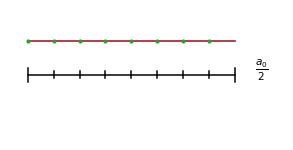

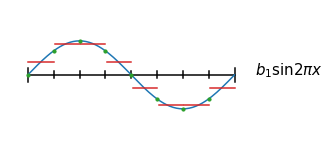

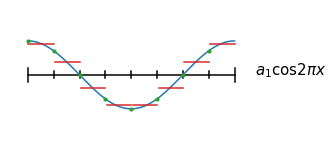

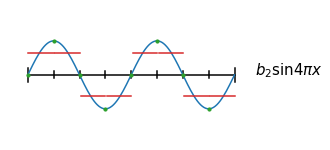

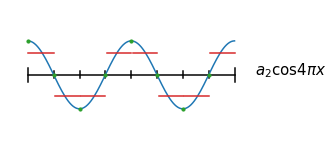

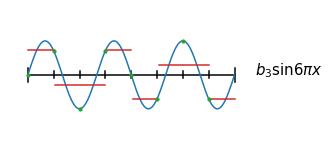

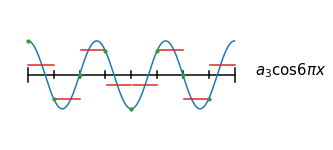

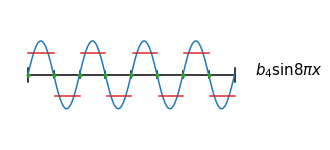

[[ 1.00000000e+00  0.00000000e+00 -4.16333634e-17 -2.77555756e-17
  -5.55111512e-17  0.00000000e+00 -2.77555756e-17  0.00000000e+00]
 [-1.52655666e-16  1.00000000e+00 -1.55304517e-17 -1.25499682e-17
   1.05703078e-16  1.56516241e-17  5.54463932e-17  1.02624158e-17]
 [-8.32667268e-17  4.64082329e-18  1.00000000e+00 -2.51832711e-17
  -1.04944768e-16 -2.65328611e-17  1.97166921e-17 -2.95081908e-17]
 [-8.32667268e-17  5.13915555e-17  7.76178438e-18  1.00000000e+00
  -3.96840781e-17  2.84742468e-17 -3.34479128e-17  6.34482490e-17]
 [-1.38777878e-16  1.42436338e-16 -1.24405438e-16 -2.91211609e-17
   1.00000000e+00  2.15667931e-16 -1.37272289e-16 -4.69903534e-17]
 [ 0.00000000e+00  5.47376751e-17 -5.35521977e-17  1.73057920e-16
   3.28446015e-16  1.00000000e+00 -6.26516354e-17  2.97006223e-16]
 [-8.32667268e-17  8.17644566e-17 -5.49106588e-17 -3.47453059e-17
  -1.43664846e-16 -6.55529232e-17  1.00000000e+00 -1.88401517e-16]
 [ 0.00000000e+00  3.16515013e-18 -6.43500350e-17  7.83384452e-17
  -

In [5]:
omegaF = BT.Grid(8)
wavesF = WT.MakeWaves(omegaF)
wavesNodeF = WT.MakeNodeWaves(omegaF)
PT.PlotWaves(omegaF, wavesF, wavesNodeF, plotNode = True)
fft_F = wavesF.transpose() # forward FFT on fine grid, but needs "unit amplitude" scaling
d = np.diag(fft_F @ wavesF) # this is the scaling for each wave #
fft_F = np.diag(1 / d) @ fft_F # this corrects for scaling
print(fft_F @ wavesF) # should be identity
invfft_F = np.linalg.inv(fft_F) # inverse FFT on coarse grid
assert(np.linalg.norm(invfft_F - wavesF, 'fro') < 1e-14)  # This should get us back the exact same amplitude modes

### Composite AMR FFT requirements list
    
Our composite FV_FFT should:
  1. Reproduce coarse grid modes exactly (same amplitude / coefs)
  2. Remaining fine grid modes should not contribute to coarse grid modes when restricted
    * Meaning they are in the null space of restriction 6->4 on coarse
    * Note, these are modes 5,8 (index 4,7) in the ones you plotted!
  3. Handle the FFT mode scaling issues between fine (8 points), composite (2+4=6 points), and coarse (4 points)
    * Means everything should be "unit amplitude" like your plots

In [6]:
np.set_printoptions(linewidth = 1000)

# 0. Test cases
# 0.1 One of the coarse wave modes on composite grid
# phi = np.reshape(2 * waves[:,1],[6,1]) # 0-3 are valid coarse wave modes
# print(phi)

# 0.2 One of the fine wave modes on composite grid
# phi = np.reshape(2 * waves[:,4],[6,1]) # 4 or 7 are valid fine wave modes
# print(phi)

# 0.3 Combine one coarse and one fine wave modes on composite grid
phi = np.reshape(1 * waves[:,2] - 2 * waves[:,7],[6,1]) # 0-3 are valid coarse wave modes
print("phi\n",phi)

# 1.1 This creates a 4 x 6 matrix to restrict composite to coarse
restrictToC = zeros([4, 6])
restrictToC[0:2,0:2] = np.eye(2,2)
restrictToC[2,2:4] = [.5, .5]
restrictToC[3,4:6] = [.5, .5]

# 1.2 Restrict it and calculate the Fourier coefs
phi_C = restrictToC @ phi
phihat_C = fft_C @ phi_C
print("phihat_C\n", phihat_C)

# 1.3 inverse FFT is just multiply by waves (unit amplitude assumption)
phihat = zeros([6,1])
phihat[0:4] = phihat_C
invfft = waves[:,[0,1,2,3,4,7]];
phi_C_only = invfft @ phihat

# 2.0 Calculate the fine Fourier coefs using just those rows from the fine FFT
# acting on just the fine values (after subtracting off the coarse mode contributions)
phi_F_only = phi - phi_C_only;
print("phi_F_only\n", phi_F_only)
# print(fft_F[:,(4,7)]) # just the FFT for the 2 fine modes
phihat_F = fft_F[(4,7),4:8] @ phi_F_only[2:6]
print("phihat_F\n", phihat_F)
phihat_F = 2 * phihat_F # TODO - since we're only using 1/2 the fine domain?

# 3.0 Finally, assemble all the fourier coefs and make sure they are correct
phihat[4:6] = phihat_F
phi_test = invfft @ phihat
print("diff:\n", phi_test - phi)

phi
 [[ 0.63661977]
 [-0.63661977]
 [-2.17355586]
 [ 0.90031632]
 [-0.90031632]
 [ 2.17355586]]
phihat_C
 [[-2.77555756e-17]
 [ 0.00000000e+00]
 [ 1.00000000e+00]
 [-2.77555756e-17]]
phi_F_only
 [[ 2.22044605e-16]
 [-1.11022302e-16]
 [-1.27323954e+00]
 [ 1.27323954e+00]
 [-1.27323954e+00]
 [ 1.27323954e+00]]
phihat_F
 [[ 5.55111512e-17]
 [-1.00000000e+00]]
diff:
 [[-2.22044605e-16]
 [ 1.11022302e-16]
 [ 0.00000000e+00]
 [ 1.11022302e-16]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
